<a href="https://colab.research.google.com/github/SFStefenon/EWT-Seq2Seq-LSTM-Attention/blob/main/EWT_Seq2Seq_LSTM_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Optimized EWT-Seq2Seq-LSTM with Attention Mechanism

Wrote by Dr. **Laio Oriel Seman** and Dr. **Stefano Frizzo Stefenon**. 

Trento, Italy, March 03, 2023.


The proposed analysis is divided according to the models evaluated:

> **Seq2Seq-LSTM with Attention**: Evaluation of the starting model using the Attention Mechanism.

> **Optimized Seq2Seq-LSTM with Attention**: Evaluation of the model with the optimized hyperparameters (based on Optuna).

> **Standard Seq2Seq LSTM**: Standard model for comparative purposes.







The definition of the number of epochs and the number of experiments results in a significant variation in simulation time.


In [ ]:
# Number of epochs
# Recommended at least 100
epc = 100

# Number of experiments to perform a statistical analysis
# Recommended at least 50
statistics = 5

# Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import time

from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping

!pip install -q ewtpy
import ewtpy
!pip install -q optuna
import optuna
!pip install -q phik
import phik
from phik import resources, report

# Load the Dataset

In [ ]:
# Load the dataset
mydata=np.loadtxt('Data.csv', delimiter=",", dtype=np.float32, skiprows=1)

insu1=mydata[:,[0]]
insu2=mydata[:,[1]] 
insu3=mydata[:,[2]] 
insu4=mydata[:,[3]] 
insu5=mydata[:,[4]] 
insu6=mydata[:,[5]] 

Definition of the insulators based on the correlation of the time series.

In [ ]:
# Preparing the dataset
x1 = insu1[::100].flatten()
x2 = insu2[::100].flatten()
x3 = insu3[::100].flatten()
x4 = insu4[::100].flatten()
x5 = insu5[::100].flatten()
x6 = insu6[::100].flatten()

# Creating the dataframe
dfphi = pd.DataFrame({'Insulator 1': x1, 'Insulator 2': x2, 'Insulator 3': x3, 'Insulator 4': x4, 'Insulator 5': x5, 'Insulator 6': x6})

# Generating the report (report with the correlation)
# report.correlation_report(dfphi, pdf_file_name='report.pdf')

In this evaluation, samples 2 and 3 had the best correlation. For this reason, they were considered for the sequence-to-sequence evaluation.

In [ ]:
# Definition of a limit (after that the flashover happens)
insu2_limit = insu2[:94000]
insu3_limit = insu3[:94000]

# Preprocessing (downsample)
x1 = insu2_limit[::100]
x2 = insu3_limit[::100]

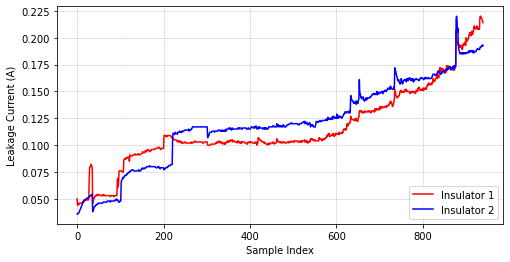

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(x1)), x1, 'r', zorder=2, label='Insulator 1')
plt.plot(range(len(x2)), x2, 'b', zorder=2, label='Insulator 2')
plt.legend(loc='lower right', fancybox=True, shadow=False, ncol=1)
plt.xlabel('Sample Index')
plt.ylabel('Leakage Current (A)')
plt.grid(linestyle = '--', linewidth = 0.5, zorder=0)
plt.show()
# plt.savefig('LeakageCurrent.pdf')

# Empirical Wavelet Transform (EWT)

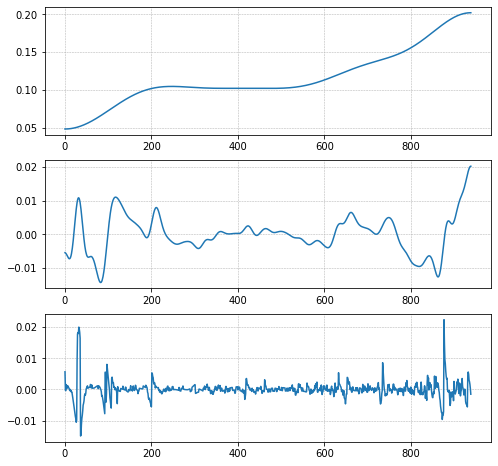

In [ ]:
f1 = x1.flatten()
f2 = x2.flatten()

ewt1, mfb1, boundaries1 = ewtpy.EWT1D(f1, N = 3)
ewt2, mfb2, boundaries2 = ewtpy.EWT1D(f2, N = 3)

plt.figure(figsize=(8, 8))
for i in range(ewt1.shape[1]):
    plt.subplot(ewt1.shape[1], 1, i+1)
    plt.plot(ewt1[:,i])
    plt.grid(linestyle = '--', linewidth = 0.5, zorder=0)
    # plt.savefig('EWT.pdf')

<function matplotlib.pyplot.show(close=None, block=None)>

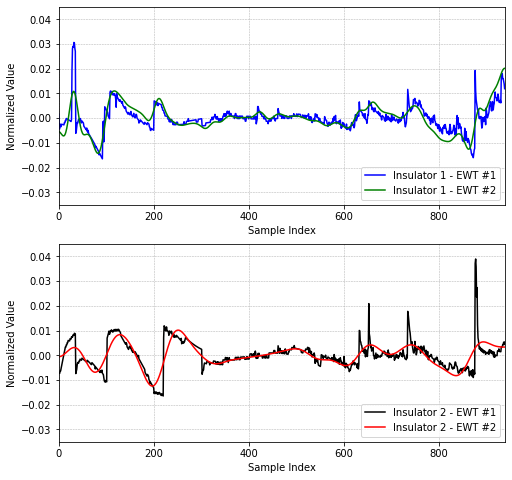

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(8, 8))

ax1.plot(x1.flatten() - ewt1[:,0], 'b', zorder=2, label='Insulator 1 - EWT #1')
ax1.plot(ewt1[:,1], 'g', zorder=2, label='Insulator 1 - EWT #2')
ax1.set_ylabel('Normalized Value')
ax1.set_xlabel('Sample Index')
ax1.axis([0, len(x1), -0.035, 0.045])
ax1.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax1.legend(loc='lower right', fancybox=True, shadow=False, ncol=1)

ax2.plot(x2.flatten() - ewt2[:,0], 'k', zorder=2, label='Insulator 2 - EWT #1')
ax2.plot(ewt2[:,1], 'r', zorder=2, label='Insulator 2 - EWT #2')
ax2.set_ylabel('Normalized Value')
ax2.set_xlabel('Sample Index')
ax2.axis([0, len(x1), -0.035, 0.045])
ax2.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax2.legend(loc='lower right', fancybox=True, shadow=False, ncol=1)
plt.show 
# plt.savefig('Normalized.pdf')

## Organize the data

In [ ]:
# Definition of dataset setup for comparison
train_ratio = 0.7
batch_siz = 16

t = np.linspace(0, 50*np.pi, len(x1))
train_len = int(train_ratio * t.shape[0])
x_index = np.array(range(len(t)))

In [ ]:
# Data normalization
x_lbl = np.column_stack([x1.flatten() - ewt1[:,0], ewt1[:,1], x2.flatten() - ewt2[:,0], ewt2[:,1], [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)

# Perform min-max normalization
x_normalize = x_lbl.copy()

(940, 5)


In [ ]:
# Organized truncat, smaller train_len and smaller test_len, to decrease the steps
def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)

X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(4), target_cols=range(4), 
                            label_col=4, train_len=10, test_len=5)
print(X_in.shape, X_out.shape, lbl.shape)

X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]

(926, 10, 4) (926, 5, 4) (926,)


# Model Evaluation 1: Seq2Seq-LSTM with Attention

## Model evaluation

In [ ]:
# Initial number of hidden neurons
n_hidden = 100

input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=True, return_sequences=True)(input_train)
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)

decoder_combined_context = concatenate([context, decoder_stack_h])
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)

model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae', 'mape'])

# Evaluate the time for training the model
inicio = time.time()

# EWT considered
TOTAL = 3

es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :TOTAL], X_output_train[:, :, :TOTAL], validation_split=0.2, epochs=epc, verbose=1, callbacks=[es], batch_size=batch_siz)

train_loss = history.history['loss']
valid_loss = history.history['val_loss']
mse = history.history['mse']
mae = history.history['mae']
mape = history.history['mape']
model.save('model_forecasting_seq2seq.h5')

train_pred_detrend = model.predict(X_input_train[:, :, :TOTAL])
test_pred_detrend = model.predict(X_input_test[:, :, :TOTAL])
train_true_detrend = X_output_train[:, :, :TOTAL]
test_true_detrend = X_output_test[:, :, :TOTAL]
data_final = dict()

fim = time.time()
time_s = fim - inicio

print('\nTime: {:.2f}'.format(time_s))
print('MSE: {0:.2e}'.format(mse[-1])) 
print('MAE: {0:.2e}'.format(mae[-1]))
print('MAPE: {0:.2e}'.format(mape[-1]))

Epoch 1/100
33/33 [==============================] - 18s 231ms/step - loss: 6.9877e-05 - mse: 6.9877e-05 - mae: 0.0060 - mape: 651.2137 - val_loss: 2.5433e-05 - val_mse: 2.5433e-05 - val_mae: 0.0040 - val_mape: 563.8717
Epoch 2/100
33/33 [==============================] - 5s 153ms/step - loss: 2.8374e-05 - mse: 2.8374e-05 - mae: 0.0038 - mape: 411.1325 - val_loss: 1.1318e-04 - val_mse: 1.1318e-04 - val_mae: 0.0099 - val_mape: 1336.9562
Epoch 3/100
33/33 [==============================] - 6s 196ms/step - loss: 1.8644e-05 - mse: 1.8644e-05 - mae: 0.0030 - mape: 325.0027 - val_loss: 1.1403e-04 - val_mse: 1.1403e-04 - val_mae: 0.0088 - val_mape: 2169.8799
Epoch 4/100
33/33 [==============================] - 5s 138ms/step - loss: 1.7136e-05 - mse: 1.7136e-05 - mae: 0.0028 - mape: 274.6412 - val_loss: 1.2647e-05 - val_mse: 1.2647e-05 - val_mae: 0.0027 - val_mape: 707.7227
Epoch 5/100
33/33 [==============================] - 2s 73ms/step - loss: 1.9187e-05 - mse: 1.9187e-05 - mae: 0.0030 - ma

## Plot Result

<function matplotlib.pyplot.show(close=None, block=None)>

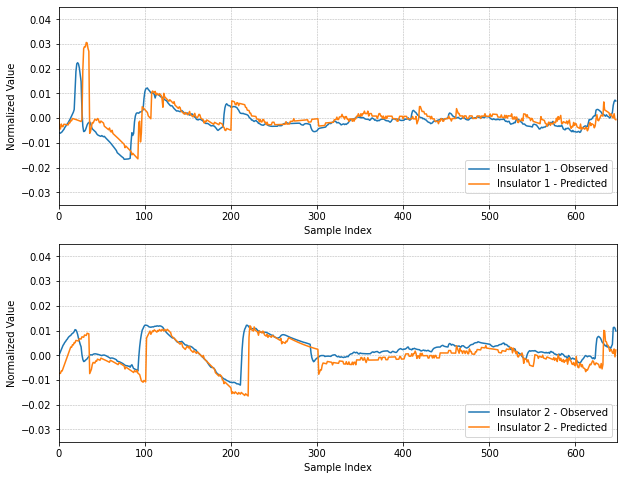

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(train_pred_detrend[:,0,0], zorder=2, label='Insulator 1 - Observed')
ax1.plot(X_input_train[:,0,0], zorder=2, label='Insulator 1 - Predicted')
ax1.set_ylabel('Normalized Value')
ax1.set_xlabel('Sample Index')
ax1.axis([0, len(train_pred_detrend[:,0,0]), -0.035, 0.045])
ax1.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax1.legend(loc="upper right", bbox_to_anchor=(1, 0.25), fancybox=True, shadow=False, ncol=1)

ax2.plot(train_pred_detrend[:,0,2], zorder=2, label='Insulator 2 - Observed')
ax2.plot(X_input_train[:,0,2],zorder=2, label='Insulator 2 - Predicted')
ax2.set_ylabel('Normalized Value')
ax2.set_xlabel('Sample Index')
ax2.axis([0, len(train_pred_detrend[:,0,0]), -0.035, 0.045])
ax2.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax2.legend(loc='lower right', fancybox=True, shadow=False, ncol=1)
plt.show 
# plt.savefig('Pred_1.pdf')

# Hyperparameters Optimization (Optuna)

In [ ]:
def attention(n_hidden, ativacao, lr):

    input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
    output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

    encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(n_hidden, activation=ativacao, dropout=0.2, recurrent_dropout=0.2, return_state=True, return_sequences=True)(input_train)
    encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
    encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

    decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
    decoder_stack_h = LSTM(n_hidden, activation=ativacao, dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

    attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
    attention = Activation('softmax')(attention)
    context = dot([attention, encoder_stack_h], axes=[2,1])
    context = BatchNormalization(momentum=0.6)(context)

    decoder_combined_context = concatenate([context, decoder_stack_h])
    out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)

    model = Model(inputs=input_train, outputs=out)
    opt = Adam(learning_rate=lr)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae', 'mape'])

    for i in range(1):
        es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
        history = model.fit(X_input_train[:, :, :TOTAL], X_output_train[:, :, :TOTAL], validation_split=0.2, epochs=epc, verbose=1, callbacks=[es], batch_size=batch_siz)

        train_loss = history.history['loss']
        valid_loss = history.history['val_loss']
        mse = history.history['mse']
        mae = history.history['mae']
        mape = history.history['mape']
        model.save('model_forecasting_seq2seq.h5')

        train_pred_detrend = model.predict(X_input_train[:, :, :TOTAL])
        test_pred_detrend = model.predict(X_input_test[:, :, :TOTAL])
        train_true_detrend = X_output_train[:, :, :TOTAL]
        test_true_detrend = X_output_test[:, :, :TOTAL]
        data_final = dict()

    return mse[-1]

def objective(trial):
    x = trial.suggest_int('hidden_units', 10, 100)
    ativacao = trial.suggest_categorical("activation", ['relu', 'elu', 'tanh'])
    lr = trial.suggest_float('learning_rate', 0.001, 0.1)
    erro = attention(x, ativacao, lr)
    return erro

study = optuna.create_study()
study.optimize(objective, n_trials=10)

study.best_params  # E.g. {'x': 2.002108042}

[I 2023-03-06 12:10:56,763] A new study created in memory with name: no-name-a378267c-f370-480c-b7a3-30e8d341c58e


Epoch 1/100
33/33 [==============================] - 12s 129ms/step - loss: 2.8919e-04 - mse: 2.8919e-04 - mae: 0.0112 - mape: 1443.7664 - val_loss: 1.6703e-05 - val_mse: 1.6703e-05 - val_mae: 0.0033 - val_mape: 425.8022
Epoch 2/100
33/33 [==============================] - 2s 72ms/step - loss: 2.8545e-05 - mse: 2.8545e-05 - mae: 0.0038 - mape: 321.8771 - val_loss: 1.4962e-05 - val_mse: 1.4962e-05 - val_mae: 0.0030 - val_mape: 392.9543
Epoch 3/100
33/33 [==============================] - 2s 64ms/step - loss: 2.3202e-05 - mse: 2.3202e-05 - mae: 0.0033 - mape: 320.8879 - val_loss: 1.6610e-05 - val_mse: 1.6610e-05 - val_mae: 0.0031 - val_mape: 616.4187
Epoch 4/100
33/33 [==============================] - 2s 70ms/step - loss: 2.0949e-05 - mse: 2.0949e-05 - mae: 0.0031 - mape: 293.6327 - val_loss: 7.5773e-06 - val_mse: 7.5773e-06 - val_mae: 0.0021 - val_mape: 342.7128
Epoch 5/100
33/33 [==============================] - 2s 65ms/step - loss: 1.9516e-05 - mse: 1.9516e-05 - mae: 0.0030 - mape: 

[I 2023-03-06 12:15:16,208] Trial 0 finished with value: 1.760158374963794e-05 and parameters: {'hidden_units': 13, 'activation': 'relu', 'learning_rate': 0.016828751559430893}. Best is trial 0 with value: 1.760158374963794e-05.


Epoch 1/100
33/33 [==============================] - 12s 88ms/step - loss: 0.0090 - mse: 0.0090 - mae: 0.0514 - mape: 8230.1240 - val_loss: 1.6852e-04 - val_mse: 1.6852e-04 - val_mae: 0.0113 - val_mape: 2684.7695
Epoch 2/100
33/33 [==============================] - 2s 70ms/step - loss: 8.4601e-05 - mse: 8.4601e-05 - mae: 0.0070 - mape: 800.9440 - val_loss: 1.0247e-05 - val_mse: 1.0247e-05 - val_mae: 0.0022 - val_mape: 563.9208
Epoch 3/100
33/33 [==============================] - 2s 70ms/step - loss: 2.6574e-05 - mse: 2.6574e-05 - mae: 0.0038 - mape: 319.4429 - val_loss: 1.7805e-05 - val_mse: 1.7805e-05 - val_mae: 0.0032 - val_mape: 974.0298
Epoch 4/100
33/33 [==============================] - 3s 106ms/step - loss: 2.1501e-05 - mse: 2.1501e-05 - mae: 0.0032 - mape: 249.6976 - val_loss: 1.2396e-05 - val_mse: 1.2396e-05 - val_mae: 0.0029 - val_mape: 330.4926
Epoch 5/100
33/33 [==============================] - 2s 66ms/step - loss: 2.0839e-05 - mse: 2.0839e-05 - mae: 0.0032 - mape: 281.058

[I 2023-03-06 12:18:48,968] Trial 1 finished with value: 1.95676493603969e-05 and parameters: {'hidden_units': 97, 'activation': 'relu', 'learning_rate': 0.037624889033322007}. Best is trial 0 with value: 1.760158374963794e-05.


Epoch 1/100
33/33 [==============================] - 11s 102ms/step - loss: 0.0190 - mse: 0.0190 - mae: 0.0772 - mape: 11609.5566 - val_loss: 6.2437e-04 - val_mse: 6.2437e-04 - val_mae: 0.0246 - val_mape: 4472.9819
Epoch 2/100
33/33 [==============================] - 2s 65ms/step - loss: 1.7957e-04 - mse: 1.7957e-04 - mae: 0.0101 - mape: 1276.0481 - val_loss: 2.6897e-05 - val_mse: 2.6897e-05 - val_mae: 0.0040 - val_mape: 859.7402
Epoch 3/100
33/33 [==============================] - 2s 66ms/step - loss: 5.9382e-05 - mse: 5.9382e-05 - mae: 0.0059 - mape: 759.5158 - val_loss: 4.8488e-05 - val_mse: 4.8488e-05 - val_mae: 0.0060 - val_mape: 1266.7958
Epoch 4/100
33/33 [==============================] - 2s 70ms/step - loss: 4.3724e-05 - mse: 4.3724e-05 - mae: 0.0050 - mape: 590.6613 - val_loss: 7.9551e-06 - val_mse: 7.9551e-06 - val_mae: 0.0019 - val_mape: 527.8049
Epoch 5/100
33/33 [==============================] - 3s 102ms/step - loss: 3.9401e-05 - mse: 3.9401e-05 - mae: 0.0048 - mape: 567

[I 2023-03-06 12:23:08,870] Trial 2 finished with value: 1.620278271730058e-05 and parameters: {'hidden_units': 89, 'activation': 'elu', 'learning_rate': 0.04167753675203832}. Best is trial 2 with value: 1.620278271730058e-05.


Epoch 1/100
33/33 [==============================] - 12s 108ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0382 - mape: 4955.6855 - val_loss: 1.0265e-04 - val_mse: 1.0265e-04 - val_mae: 0.0086 - val_mape: 2345.1323
Epoch 2/100
33/33 [==============================] - 4s 111ms/step - loss: 9.7348e-05 - mse: 9.7348e-05 - mae: 0.0075 - mape: 987.9689 - val_loss: 1.6093e-05 - val_mse: 1.6093e-05 - val_mae: 0.0036 - val_mape: 502.5938
Epoch 3/100
33/33 [==============================] - 2s 72ms/step - loss: 3.9284e-05 - mse: 3.9284e-05 - mae: 0.0048 - mape: 570.7772 - val_loss: 2.9433e-05 - val_mse: 2.9433e-05 - val_mae: 0.0040 - val_mape: 661.5016
Epoch 4/100
33/33 [==============================] - 2s 69ms/step - loss: 3.3486e-05 - mse: 3.3486e-05 - mae: 0.0044 - mape: 524.3654 - val_loss: 7.2967e-05 - val_mse: 7.2967e-05 - val_mae: 0.0071 - val_mape: 1342.3435
Epoch 5/100
33/33 [==============================] - 2s 69ms/step - loss: 5.0418e-05 - mse: 5.0418e-05 - mae: 0.0055 - mape: 660.0

[I 2023-03-06 12:27:39,282] Trial 3 finished with value: 2.992783447552938e-05 and parameters: {'hidden_units': 48, 'activation': 'elu', 'learning_rate': 0.04005706489187335}. Best is trial 2 with value: 1.620278271730058e-05.


Epoch 1/100
33/33 [==============================] - 11s 128ms/step - loss: 2.2010e-04 - mse: 2.2010e-04 - mae: 0.0101 - mape: 1130.6073 - val_loss: 3.2722e-04 - val_mse: 3.2722e-04 - val_mae: 0.0170 - val_mape: 3245.6538
Epoch 2/100
33/33 [==============================] - 2s 68ms/step - loss: 2.5646e-05 - mse: 2.5646e-05 - mae: 0.0037 - mape: 396.3203 - val_loss: 7.1544e-05 - val_mse: 7.1544e-05 - val_mae: 0.0080 - val_mape: 1058.0972
Epoch 3/100
33/33 [==============================] - 2s 70ms/step - loss: 3.5164e-05 - mse: 3.5164e-05 - mae: 0.0046 - mape: 594.7603 - val_loss: 1.4212e-04 - val_mse: 1.4212e-04 - val_mae: 0.0090 - val_mape: 938.8074
Epoch 4/100
33/33 [==============================] - 2s 70ms/step - loss: 1.7049e-05 - mse: 1.7049e-05 - mae: 0.0030 - mape: 312.8646 - val_loss: 7.8348e-05 - val_mse: 7.8348e-05 - val_mae: 0.0075 - val_mape: 1208.6261
Epoch 5/100
33/33 [==============================] - 3s 87ms/step - loss: 1.8484e-05 - mse: 1.8484e-05 - mae: 0.0031 - map

[I 2023-03-06 12:32:02,979] Trial 4 finished with value: 1.10111277535907e-05 and parameters: {'hidden_units': 39, 'activation': 'tanh', 'learning_rate': 0.004229321071804456}. Best is trial 4 with value: 1.10111277535907e-05.


Epoch 1/100
33/33 [==============================] - 10s 94ms/step - loss: 0.0502 - mse: 0.0502 - mae: 0.1256 - mape: 18240.0625 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0359 - val_mape: 4436.7744
Epoch 2/100
33/33 [==============================] - 3s 91ms/step - loss: 5.1863e-04 - mse: 5.1863e-04 - mae: 0.0174 - mape: 2213.7393 - val_loss: 9.8906e-05 - val_mse: 9.8905e-05 - val_mae: 0.0089 - val_mape: 2054.0002
Epoch 3/100
33/33 [==============================] - 2s 66ms/step - loss: 1.0085e-04 - mse: 1.0085e-04 - mae: 0.0079 - mape: 1116.9531 - val_loss: 1.2497e-05 - val_mse: 1.2497e-05 - val_mae: 0.0029 - val_mape: 313.8097
Epoch 4/100
33/33 [==============================] - 2s 66ms/step - loss: 6.6810e-05 - mse: 6.6810e-05 - mae: 0.0063 - mape: 824.3115 - val_loss: 1.5747e-05 - val_mse: 1.5747e-05 - val_mae: 0.0033 - val_mape: 424.8109
Epoch 5/100
33/33 [==============================] - 2s 67ms/step - loss: 6.3279e-05 - mse: 6.3279e-05 - mae: 0.0062 - mape: 795.9838 - v

[I 2023-03-06 12:36:32,271] Trial 5 finished with value: 2.5709776309668086e-05 and parameters: {'hidden_units': 85, 'activation': 'tanh', 'learning_rate': 0.05375445999487049}. Best is trial 4 with value: 1.10111277535907e-05.


Epoch 1/100
33/33 [==============================] - 12s 88ms/step - loss: 0.0208 - mse: 0.0208 - mae: 0.0751 - mape: 11054.2207 - val_loss: 2.3244e-04 - val_mse: 2.3244e-04 - val_mae: 0.0115 - val_mape: 1761.8081
Epoch 2/100
33/33 [==============================] - 2s 66ms/step - loss: 2.0779e-04 - mse: 2.0779e-04 - mae: 0.0113 - mape: 1571.1927 - val_loss: 4.8764e-05 - val_mse: 4.8764e-05 - val_mae: 0.0061 - val_mape: 1559.8917
Epoch 3/100
33/33 [==============================] - 2s 67ms/step - loss: 1.0985e-04 - mse: 1.0985e-04 - mae: 0.0083 - mape: 1021.5030 - val_loss: 1.0670e-04 - val_mse: 1.0670e-04 - val_mae: 0.0082 - val_mape: 1087.1404
Epoch 4/100
33/33 [==============================] - 5s 139ms/step - loss: 1.9021e-04 - mse: 1.9021e-04 - mae: 0.0106 - mape: 1433.8191 - val_loss: 1.1433e-04 - val_mse: 1.1433e-04 - val_mae: 0.0078 - val_mape: 1057.2222
Epoch 5/100
33/33 [==============================] - 4s 135ms/step - loss: 1.0006e-04 - mse: 1.0006e-04 - mae: 0.0078 - mape:

[I 2023-03-06 12:42:03,563] Trial 6 finished with value: 2.7549243895919062e-05 and parameters: {'hidden_units': 35, 'activation': 'tanh', 'learning_rate': 0.07329761573657563}. Best is trial 4 with value: 1.10111277535907e-05.


Epoch 1/100
33/33 [==============================] - 11s 88ms/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0428 - mape: 7002.6504 - val_loss: 2.1243e-04 - val_mse: 2.1243e-04 - val_mae: 0.0140 - val_mape: 2226.2939
Epoch 2/100
33/33 [==============================] - 2s 74ms/step - loss: 5.1967e-05 - mse: 5.1967e-05 - mae: 0.0054 - mape: 608.7980 - val_loss: 9.0376e-06 - val_mse: 9.0376e-06 - val_mae: 0.0022 - val_mape: 384.8059
Epoch 3/100
33/33 [==============================] - 3s 96ms/step - loss: 2.5818e-05 - mse: 2.5818e-05 - mae: 0.0037 - mape: 358.7467 - val_loss: 5.9864e-06 - val_mse: 5.9864e-06 - val_mae: 0.0016 - val_mape: 263.1762
Epoch 4/100
33/33 [==============================] - 2s 67ms/step - loss: 2.4953e-05 - mse: 2.4953e-05 - mae: 0.0037 - mape: 425.9978 - val_loss: 1.1128e-05 - val_mse: 1.1128e-05 - val_mae: 0.0027 - val_mape: 342.5278
Epoch 5/100
33/33 [==============================] - 2s 66ms/step - loss: 2.4635e-05 - mse: 2.4635e-05 - mae: 0.0036 - mape: 376.0396

[I 2023-03-06 12:46:33,684] Trial 7 finished with value: 1.732190139591694e-05 and parameters: {'hidden_units': 60, 'activation': 'relu', 'learning_rate': 0.045279780485678496}. Best is trial 4 with value: 1.10111277535907e-05.


Epoch 1/100
33/33 [==============================] - 12s 92ms/step - loss: 0.0780 - mse: 0.0780 - mae: 0.1601 - mape: 24809.9141 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae: 0.0597 - val_mape: 7564.2778
Epoch 2/100
33/33 [==============================] - 2s 69ms/step - loss: 9.6879e-04 - mse: 9.6879e-04 - mae: 0.0234 - mape: 2968.8054 - val_loss: 4.4465e-05 - val_mse: 4.4465e-05 - val_mae: 0.0060 - val_mape: 1062.5804
Epoch 3/100
33/33 [==============================] - 2s 72ms/step - loss: 1.8278e-04 - mse: 1.8278e-04 - mae: 0.0107 - mape: 1496.1053 - val_loss: 6.3879e-04 - val_mse: 6.3879e-04 - val_mae: 0.0228 - val_mape: 3515.4092
Epoch 4/100
33/33 [==============================] - 3s 94ms/step - loss: 6.1604e-04 - mse: 6.1604e-04 - mae: 0.0193 - mape: 3033.6760 - val_loss: 6.1268e-04 - val_mse: 6.1268e-04 - val_mae: 0.0211 - val_mape: 2139.8828
Epoch 5/100
33/33 [==============================] - 3s 83ms/step - loss: 3.7299e-04 - mse: 3.7299e-04 - mae: 0.0151 - mape: 2238.5852

[I 2023-03-06 12:51:04,861] Trial 8 finished with value: 2.6191564757027663e-05 and parameters: {'hidden_units': 54, 'activation': 'tanh', 'learning_rate': 0.09755188858724709}. Best is trial 4 with value: 1.10111277535907e-05.


Epoch 1/100
33/33 [==============================] - 10s 91ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0270 - mape: 2996.9351 - val_loss: 2.4515e-04 - val_mse: 2.4515e-04 - val_mae: 0.0115 - val_mape: 1995.9177
Epoch 2/100
33/33 [==============================] - 3s 106ms/step - loss: 5.6891e-05 - mse: 5.6891e-05 - mae: 0.0057 - mape: 685.7776 - val_loss: 3.4264e-05 - val_mse: 3.4264e-05 - val_mae: 0.0052 - val_mape: 587.8142
Epoch 3/100
33/33 [==============================] - 2s 67ms/step - loss: 3.0365e-05 - mse: 3.0365e-05 - mae: 0.0042 - mape: 514.8571 - val_loss: 1.5924e-05 - val_mse: 1.5924e-05 - val_mae: 0.0033 - val_mape: 576.9730
Epoch 4/100
33/33 [==============================] - 2s 69ms/step - loss: 2.4966e-05 - mse: 2.4966e-05 - mae: 0.0037 - mape: 395.6691 - val_loss: 1.3709e-05 - val_mse: 1.3709e-05 - val_mae: 0.0029 - val_mape: 741.8680
Epoch 5/100
33/33 [==============================] - 2s 67ms/step - loss: 3.9324e-05 - mse: 3.9324e-05 - mae: 0.0049 - mape: 634.036

[I 2023-03-06 12:54:34,721] Trial 9 finished with value: 1.7003174434648827e-05 and parameters: {'hidden_units': 17, 'activation': 'elu', 'learning_rate': 0.034506956288415144}. Best is trial 4 with value: 1.10111277535907e-05.


{'hidden_units': 39,
 'activation': 'tanh',
 'learning_rate': 0.004229321071804456}

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_contour(study, params=["hidden_units", "activation", "learning_rate"])

<ipython-input-34-e19d1e16c3db>:1: ExperimentalWarning:

plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.



<AxesSubplot:title={'center':'Parallel Coordinate Plot'}>

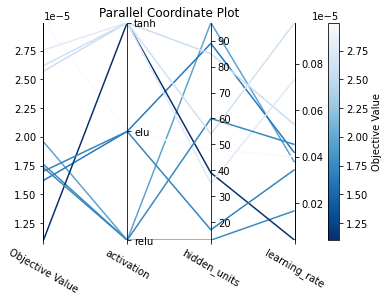

In [ ]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["hidden_units", "activation", "learning_rate"])

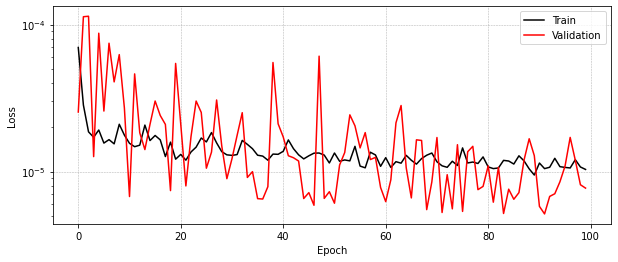

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss, 'k', zorder=2, label='Train')
plt.plot(valid_loss, 'r', zorder=2, label='Validation')
plt.legend(loc='upper right', fancybox=True, shadow=False, ncol=1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log") 
plt.grid(linestyle = '--', linewidth = 0.5, zorder=0)
plt.show()
# plt.savefig('Loss.pdf')

# Model Evaluation 2: Optimized Seq2Seq-LSTM with Attention

## Model evaluation

In [ ]:
# Number of hidden neurons defined by the optimizer
n_hidden = 78

input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(n_hidden, activation='relu', dropout=0.2, recurrent_dropout=0.2, return_state=True, return_sequences=True)(input_train)
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

# Activation function defined by the optimizer
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)

decoder_combined_context = concatenate([context, decoder_stack_h])
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
model = Model(inputs=input_train, outputs=out)

# Learning rate defined by the optimizer
opt = Adam(lr=0.013629063355056946, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae', 'mape'])

# Evaluate the time for training the model
inicio = time.time()

# EWT considered
TOTAL = 3

# To save values for statistics
MSE=[]
MAE=[]
MAPE=[]

for i in range(statistics):
  es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
  history = model.fit(X_input_train[:, :, :TOTAL], X_output_train[:, :, :TOTAL], validation_split=0.2, epochs=epc, verbose=1, callbacks=[es], batch_size=batch_siz)
  train_loss = history.history['loss']
  valid_loss = history.history['val_loss']
  mse = history.history['mse']
  mae = history.history['mae']
  mape = history.history['mape']
  model.save('model_forecasting_seq2seq.h5')

  train_pred_detrend = model.predict(X_input_train[:, :, :TOTAL])
  test_pred_detrend = model.predict(X_input_test[:, :, :TOTAL])
  train_true_detrend = X_output_train[:, :, :TOTAL]
  test_true_detrend = X_output_test[:, :, :TOTAL]
  data_final = dict()

  print(f'Simulation: {i+1}')
  MSE.append(mse[len(mse)-1])
  MAE.append(mae[len(mse)-1])
  MAPE.append(mape[len(mse)-1])

fim = time.time()
time_s = fim - inicio

print('\nTime: {:.2f}'.format(time_s))
print('MSE: {0:.2e}'.format(mse[-1])) 
print('MAE: {0:.2e}'.format(mae[-1]))
print('MAPE: {0:.2e}'.format(mape[-1]))

Epoch 1/100
33/33 [==============================] - 24s 301ms/step - loss: 4.4741e-05 - mse: 4.4741e-05 - mae: 0.0048 - mape: 527.3421 - val_loss: 1.8535e-05 - val_mse: 1.8535e-05 - val_mae: 0.0038 - val_mape: 431.3741
Epoch 2/100
33/33 [==============================] - 8s 249ms/step - loss: 1.7254e-05 - mse: 1.7254e-05 - mae: 0.0028 - mape: 280.1476 - val_loss: 6.9970e-06 - val_mse: 6.9970e-06 - val_mae: 0.0021 - val_mape: 350.0665
Epoch 3/100
33/33 [==============================] - 6s 184ms/step - loss: 1.7278e-05 - mse: 1.7278e-05 - mae: 0.0029 - mape: 333.3903 - val_loss: 1.4620e-05 - val_mse: 1.4620e-05 - val_mae: 0.0031 - val_mape: 426.1089
Epoch 4/100
33/33 [==============================] - 2s 73ms/step - loss: 1.4323e-05 - mse: 1.4323e-05 - mae: 0.0026 - mape: 282.8459 - val_loss: 1.3082e-05 - val_mse: 1.3082e-05 - val_mae: 0.0031 - val_mape: 339.7777
Epoch 5/100
33/33 [==============================] - 2s 72ms/step - loss: 1.4820e-05 - mse: 1.4820e-05 - mae: 0.0027 - mape:

In [ ]:
# Save results to csv
pd.DataFrame(MAPE).to_csv("MAPE.csv", index=True)
pd.DataFrame(MAE).to_csv("MAE.csv", index=True)
pd.DataFrame(MSE).to_csv("MSE.csv", index=True)

# To load the csv
# x=np.loadtxt('MSE.csv', delimiter=",", dtype=np.float32, skiprows=1)

# Model evaluation 3: Starndard Seq2Seq LSTM Model

In [ ]:
n_hidden = 100

input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_sequences=False, return_state=True)(input_train)
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

out = TimeDistributed(Dense(output_train.shape[2]))(decoder)

model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1) 
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae', 'mape'])

# Evaluate the time for training the model
inicio = time.time()

# EWT considered
TOTAL = 3

# To save values for statistics
MSE=[]
MAE=[]
MAPE=[]

for i in range(statistics):
  es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
  history = model.fit(X_input_train[:, :, :TOTAL], X_output_train[:, :, :TOTAL], validation_split=0.2, epochs=epc, verbose=1, callbacks=[es], batch_size=batch_siz)
  train_loss = history.history['loss']
  valid_loss = history.history['val_loss']
  mse = history.history['mse']
  mae = history.history['mae']
  mape = history.history['mape']
  model.save('model_forecasting_seq2seq.h5')

  train_pred_detrend = model.predict(X_input_train[:, :, :TOTAL])
  test_pred_detrend = model.predict(X_input_test[:, :, :TOTAL])
  train_true_detrend = X_output_train[:, :, :TOTAL]
  test_true_detrend = X_output_test[:, :, :TOTAL]
  data_final = dict()
  
  print(f'Simulation: {i+1}')
  MSE.append(mse[len(mse)-1])
  MAE.append(mae[len(mse)-1])
  MAPE.append(mape[len(mse)-1])

fim = time.time()
time_s = fim - inicio

print('\nTime: {:.2f}'.format(time_s))
print('MSE: {0:.2e}'.format(mse[-1])) 
print('MAE: {0:.2e}'.format(mae[-1]))
print('MAPE: {0:.2e}'.format(mape[-1]))

Epoch 1/100
33/33 [==============================] - 10s 113ms/step - loss: 7.8709e-05 - mse: 7.8709e-05 - mae: 0.0061 - mape: 638.4116 - val_loss: 1.4087e-04 - val_mse: 1.4087e-04 - val_mae: 0.0101 - val_mape: 2014.4131
Epoch 2/100
33/33 [==============================] - 2s 64ms/step - loss: 2.8040e-05 - mse: 2.8040e-05 - mae: 0.0037 - mape: 361.3597 - val_loss: 2.4887e-05 - val_mse: 2.4887e-05 - val_mae: 0.0039 - val_mape: 553.5855
Epoch 3/100
33/33 [==============================] - 2s 65ms/step - loss: 2.4167e-05 - mse: 2.4167e-05 - mae: 0.0035 - mape: 379.1288 - val_loss: 9.1327e-06 - val_mse: 9.1327e-06 - val_mae: 0.0025 - val_mape: 380.7848
Epoch 4/100
33/33 [==============================] - 2s 65ms/step - loss: 2.2992e-05 - mse: 2.2992e-05 - mae: 0.0035 - mape: 366.9904 - val_loss: 1.4496e-05 - val_mse: 1.4496e-05 - val_mae: 0.0032 - val_mape: 466.6611
Epoch 5/100
33/33 [==============================] - 2s 65ms/step - loss: 2.2325e-05 - mse: 2.2325e-05 - mae: 0.0034 - mape: 

In [ ]:
pd.DataFrame(MAPE).to_csv("MAPE_without_at.csv", index=True)
pd.DataFrame(MAE).to_csv("MAE_without_at.csv", index=True)
pd.DataFrame(MSE).to_csv("MSE_without_at.csv", index=True)